In [184]:
# Packages for loading data
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np

# Packages for interactive plotting
import holoviews as hv
import geoviews as gv
import hvplot.xarray
import hvplot.pandas

# Packages for plotting
from resilientplotterclass import rpc

In [ ]:
# Plot the basemap
basemap_plot = hv.element.tiles.EsriImagery()

# Plot the polygon to select the data (default polygon around Terschelling)
default_poly = [(5.0713, 53.3602), (5.2567, 53.44), (5.5281, 53.4646), (5.6351, 53.4086), (5.1669, 53.3079), (5.0713, 53.3602)]
aoi_plot = gv.Polygons(default_poly).opts(fill_alpha=0.5, color='red', line_color='red', line_width=2)
aoi_stream = hv.streams.PolyDraw(source=aoi_plot, num_objects=1, show_vertices=True)

# Combine the plots
plot = (basemap_plot * aoi_plot).opts(xlabel='Longitude WGS [deg]', ylabel='Latitude WGS [deg]', width=1200, height=600, active_tools=['poly_draw', 'wheel_zoom'],
                                                title='Select an area of interest by drawing a polygon around the data you want to extract (hold the left mouse button for a second to start and end drawing)')

# Show the plot
plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'6b8e0975-a864-45fd-9e5a-02d5bfbac7ef': {'version…

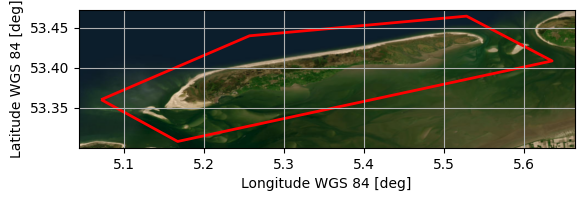

In [116]:
# Get the area of interest
aoi_data = aoi_stream.data
if len(aoi_stream.data['xs']) == 1:
    aoi = Polygon((x, y) for x, y in zip(aoi_data['xs'][0], aoi_data['ys'][0]))
else:
    aoi = Polygon()

# Create a geodataframe of the area of interest
gdf_aoi= gpd.GeoDataFrame({'Name': ['Custom'], 'geometry': [aoi]}, crs='EPSG:4326')

# Plot the area of interest
fig, ax = plt.subplots()
rpc.geometries(gdf_aoi, ax, facecolor='none', edgecolor='red', linewidth=2)
rpc.basemap(crs=gdf_aoi.crs, map_type='satellite', ax=ax)
plt.show()

In [263]:
aoi.__geo_interface__

{'type': 'Polygon',
 'coordinates': (((5.071300000000001, 53.36019999999999),
   (5.2567, 53.44),
   (5.5281, 53.46459999999999),
   (5.635100000000001, 53.40859999999999),
   (5.1669, 53.3079),
   (5.071300000000001, 53.36019999999999)),)}

In [117]:
import jinja2
from pathlib import Path
from utils.stac import STACClientGCA, ZarrDataset
from utils.zarr_slicing import ZarrSlicer
from datasets.datasetcontent import DatasetContent
from datasets.base_dataset import get_dataset_content
from dataclasses import dataclass

@dataclass
class ReportContent:
    datasets: list[DatasetContent]

def create_report_html(polygon: Polygon, stac_root: str) -> str:
    htmlpath = Path("./template.html.jinja")
    csspath = Path("./template.css")

    with htmlpath.open() as f:
        template = jinja2.Template(f.read())

    data = generate_report_content(polygon=polygon, stac_root=stac_root)
    css: str = csspath.read_bytes().decode()
    html = template.render(data=data, css=css)

    return html

def generate_report_content(polygon: Polygon, stac_root: str) -> ReportContent:
    gca_client = STACClientGCA.open(stac_root)
    zarr_datasets: list[ZarrDataset] = gca_client.get_all_zarr_uris()  # type: ignore
    
    gca_collection_dict = {'world_pop':0, 'world_gdp':1,
                            'sed_class':2, 'shore_mon':3, 'shore_mon_hr':4, 
                            'shore_mon_drivers':5, 'shore_mon_fut':6,
                            'esl_gwl':7, 'sub_threat':8 }
    
    existing_collection = [zarr_datasets[ind].dataset_id for ind in range(len(zarr_datasets))]
    existing_num = [gca_collection_dict[name] for name in existing_collection]
    
    zarr_datasets = [zarr_datasets[existing_num.index(i)] for i in range(len(gca_collection_dict))]

    ds_ls = []
    dataset_contents: list[DatasetContent] = []
    for zarr_dataset in zarr_datasets:
        xarr = ZarrSlicer._get_dataset_from_zarr_url(zarr_dataset.zarr_uri)
        sliced_xarr = ZarrSlicer.slice_xarr_with_polygon(xarr, polygon)
        if ZarrSlicer.check_xarr_contains_data(sliced_xarr):
            dataset_content = get_dataset_content(zarr_dataset.dataset_id, sliced_xarr)
            if dataset_content:
                dataset_contents.append(dataset_content)
                ds_ls.append(sliced_xarr)

    return ReportContent(datasets=dataset_contents), ds_ls

STAC_ROOT_DEFAULT = "https://raw.githubusercontent.com/openearth/global-coastal-atlas/subsidence_etienne/STAC/data/current/catalog.json"
reportContent, ds_ls = generate_report_content(polygon=aoi, stac_root=STAC_ROOT_DEFAULT)
#html = create_report_html(polygon=aoi, stac_root=STAC_ROOT_DEFAULT)

# Do not show matplotlib plots
plt.close('all')

# Set crs
ds_ls = [ds_ls[i].rio.write_crs('EPSG:4326') for i in range(len(ds_ls))]

c:\Users\white_rn\AppData\Local\miniforge3\envs\gca_env\Lib\site-packages\pystac_client\client.py:190: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())
c:\Users\white_rn\AppData\Local\miniforge3\envs\gca_env\Lib\site-packages\pystac_client\client.py:440: FallbackToPystac: Falling back to pystac. This might be slow.
  self._warn_about_fallback("COLLECTIONS", "FEATURES")


In [293]:
import matplotlib
import os
from openai import AzureOpenAI
from resilientplotterclass import rpc
import contextily as cx
%matplotlib inline

def plot_aoi(gdf_aoi):
    # Get limits
    bounds = gdf_aoi.bounds.values[0]
    center = [(bounds[0] + bounds[2]) / 2, (bounds[1] + bounds[3]) / 2]
    length = max([bounds[2] - bounds[0], bounds[3] - bounds[1]])
    buffer = 0.01
    xlims = [center[0] - length/2 - buffer, center[0] + length/2 + buffer]
    ylims = [center[1] - length/2 - buffer, center[1] + length/2 + buffer]

    # Plot data
    fig, ax = plt.subplots(figsize=(5, 5))
    rpc.geometries(gdf_aoi, ax=ax, facecolor='none', edgecolor='white', linewidth=1)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    rpc.basemap(crs=gdf_aoi.crs, map_type='satellite', ax=ax)
    ax.grid(False)
    plt.show()

def plot_changerate(ds, gdf_aoi, var='changerate'):
    # Get limits
    bounds = gdf_aoi.bounds.values[0]
    center = [(bounds[0] + bounds[2]) / 2, (bounds[1] + bounds[3]) / 2]
    length = max([bounds[2] - bounds[0], bounds[3] - bounds[1]])
    buffer = 0.01
    xlims = [center[0] - length/2 - buffer, center[0] + length/2 + buffer]
    ylims = [center[1] - length/2 - buffer, center[1] + length/2 + buffer]

    # Get pie chart data
    labels = ['Extreme\nerosion', 'Severe\nerosion', 'Intense\nerosion', 'Erosion', 'Stable', 'Accretion', 'Intense\naccretion', 'Severe\naccretion', 'Extreme\naccretion']
    colors = [matplotlib.cm.RdYlGn(i) for i in np.linspace(0.05, 0.95, len(labels))]
    bins = [-np.inf, -5, -3, -1, -0.5, 0.5 , 1, 3, 5, np.inf]
    data = np.histogram(ds_ls[2]['changerate'].values, bins=bins)[0]
    
    # Plot data
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), width_ratios=[1, 0.8, 1])
    rpc.scatter(ds, data_type='data', ax=axs[0], x='lon', y='lat', hue=var, vmin=-5, vmax=5, cmap='RdYlGn', cbar_kwargs={'label': 'Erosion/Accretion [m/yr]'})
    axs[0].set_xlim(xlims)
    axs[0].set_ylim(ylims)
    rpc.basemap(crs=ds.rio.crs, source=cx.providers.CartoDB.Positron, ax=axs[0], attribution=False)

    # Add a pie chart showing the distribution of the classes
    axs[1].pie(data, labels=labels, colors=colors, autopct='%1.0f%%', startangle=90, counterclock=False)
    axs[1].axis('equal')
    
    # Add legend
    labels2 = ['Extreme erosion (<-5 m/yr)', 'Severe erosion (-5 to -3 m/yr)', 'Intense erosion (-3 to -1 m/yr)', 'Erosion (-1 to -0.5 m/yr)', 'Stable (-0.5 to 0.5 m/yr)',
              'Accretion (0.5 to 1 m/yr)', 'Intense accretion (1 to 3 m/yr)', 'Severe accretion (3 to 5 m/yr)', 'Extreme accretion (>5 m/yr)']
    colors2 = [matplotlib.cm.RdYlGn(i) for i in np.linspace(0.05, 0.95, len(labels2))]
    axs[2].legend(handles=[matplotlib.patches.Patch(color=colors2[i], label=labels2[i]) for i in range(len(labels2))], loc='center left', frameon=False)
    axs[2].axis('off')

    fig.tight_layout()
    plt.show()

def plot_future_changerate(ds, gdf_aoi, var='changerate'):
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), width_ratios=[1, 1, 1])
    
    for ax, val, title in zip(axs, [0, -1, -2], ['Current distribution', 'Distribution in 2050', 'Distribution in 2100']):
        # Get pie chart data
        labels = ['Extreme\nerosion', 'Severe\nerosion', 'Intense\nerosion', 'Erosion', 'Stable', 'Accretion', 'Intense\naccretion', 'Severe\naccretion', 'Extreme\naccretion']
        colors = [matplotlib.cm.RdYlGn(i) for i in np.linspace(0.05, 0.95, len(labels))]
        bins = [-np.inf, -5, -3, -1, -0.5, 0.5 , 1, 3, 5, np.inf]
        data = np.histogram(ds_ls[2]['changerate'].values+val, bins=bins)[0]
    
        # Add a pie chart showing the distribution of the classes
        ax.pie(data, labels=labels, colors=colors, autopct='%1.0f%%', startangle=90, counterclock=False)
        ax.axis('equal')
        ax.set_title(title)

    # Add legend underneath all axs
    labels2 = ['Extreme erosion (<-5 m/yr)', 'Severe erosion (-5 to -3 m/yr)', 'Intense erosion (-3 to -1 m/yr)', 'Erosion (-1 to -0.5 m/yr)', 'Stable (-0.5 to 0.5 m/yr)',
            'Accretion (0.5 to 1 m/yr)', 'Intense accretion (1 to 3 m/yr)', 'Severe accretion (3 to 5 m/yr)', 'Extreme accretion (>5 m/yr)']
    colors2 = [matplotlib.cm.RdYlGn(i) for i in np.linspace(0.05, 0.95, len(labels2))]
    fig.legend(handles=[matplotlib.patches.Patch(color=colors2[i], label=labels2[i]) for i in range(len(labels2))], loc='center', frameon=False, ncol=3, bbox_to_anchor=(0.5, 0.0))
    
    fig.tight_layout()
    plt.show()

In [294]:
def describe_changerate(ds, var='changerate'):
    # Create data dictionary
    data_dict = {}
    data_dict['lon'] = {'value': np.round(ds['lon'].values, 2), 'long_name': ds['lon'].attrs['long_name'], 'units': ds['lon'].attrs['units']}
    data_dict['lat'] = {'value': np.round(ds['lat'].values, 2), 'long_name': ds['lat'].attrs['long_name'], 'units': ds['lat'].attrs['units']}
    data_dict['changerate'] = {'value': np.round(ds[var].values, 2), 'long_name': ds[var].attrs['long_name'], 'units': ds[var].attrs['units']}

    # Create changerate classes dictionary
    classes_dict = {}
    classes_dict['extreme_accretion'] = {'min': 5, 'max': np.inf, 'unit': ds[var].attrs['units']}
    classes_dict['severe_accretion'] = {'min': 3, 'max': 5, 'unit': ds[var].attrs['units']}
    classes_dict['intense_accretion'] = {'min': 1, 'max': 3, 'unit': ds[var].attrs['units']}
    classes_dict['accretion'] = {'min': 0.5, 'max': 1, 'unit': ds[var].attrs['units']}
    classes_dict['stable'] = {'min': -0.5, 'max': 0.5, 'unit': ds[var].attrs['units']}
    classes_dict['erosion'] = {'min': -1, 'max': -0.5, 'unit': ds[var].attrs['units']}
    classes_dict['intense_erosion'] = {'min': -3, 'max': -1, 'unit': ds[var].attrs['units']}
    classes_dict['severe_erosion'] = {'min': -5, 'max': -3, 'unit': ds[var].attrs['units']}
    classes_dict['extreme_erosion'] = {'min': -np.inf, 'max': -5, 'unit': ds[var].attrs['units']}


    # Create prompt
    prompt = """
    You are a coastal scientist tasked with writing a concise paragraph (maximum 100 words) for a report describing the state of the coast.
    Use the dataset below, which contains coastal change rates (positive values indicate accretion, negative values indicate erosion).
    Categorize the observed change rates using the coastal erosion classes, also provided below. Ensure the description is clear, professional,
    and aligned with the dataset's trends. Begin your paragraph with: "The coast in this area is characterized by...".
    
    * Dataset: {}
    * coastal erosion classes: {}
    """.format(str(data_dict), str(classes_dict))

    # Load environment variables
    api_version = '2024-03-01-preview'
    api_base_url = os.getenv('OPENAI_API_BASE')
    api_key = os.getenv('AZURE_OPENAI_API_KEY')
    deployment_name = os.getenv('AZURE_OPENAI_DEPLOYMENT_NAME')

    # Initialise large language model
    model = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f'{api_base_url}/deployments/{deployment_name}',
    )

    # Trigger model
    response = model.chat.completions.create(
        model=os.getenv('AZURE_OPENAI_DEPLOYMENT_NAME'),
        messages=[
            {'role': 'system', 'content': prompt},
        ],
        max_tokens=1000,
        temperature=0.1,
    )

    # Return response
    return response.choices[0].message.content

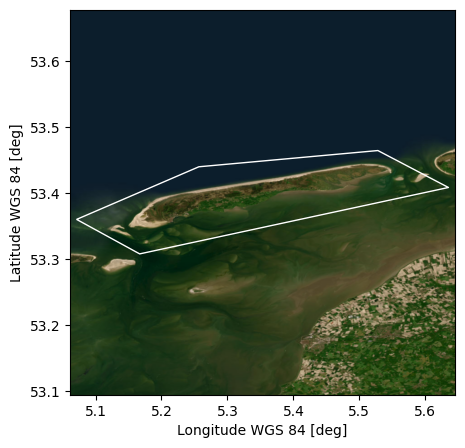

The coast in this area is characterized by a mix of accretion and erosion. Notably, there are regions of extreme accretion with rates exceeding 5 m/yr
, particularly around longitudes 5.33 to 5.3 and 5.4 to 5.44. Conversely, severe to extreme erosion is observed, especially between longitudes 5.25 to
 5.17 and 5.53, with rates reaching as low as -35.26 m/yr. Some areas exhibit stable conditions or mild changes, indicating a dynamic coastal environm
ent with significant spatial variability in coastal change rates.


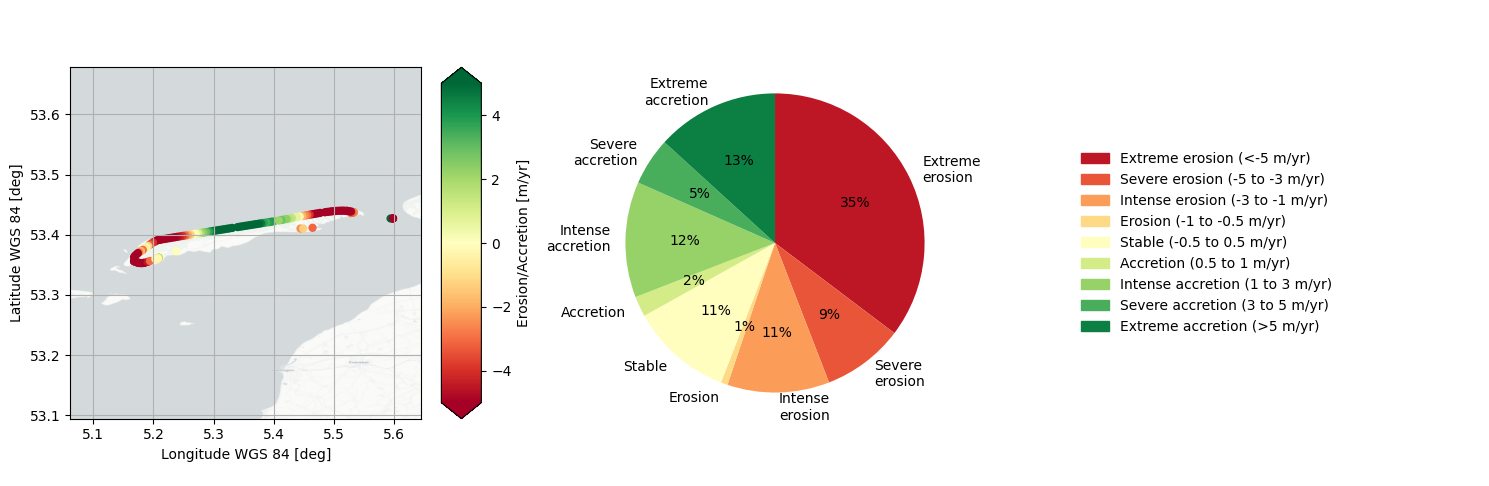

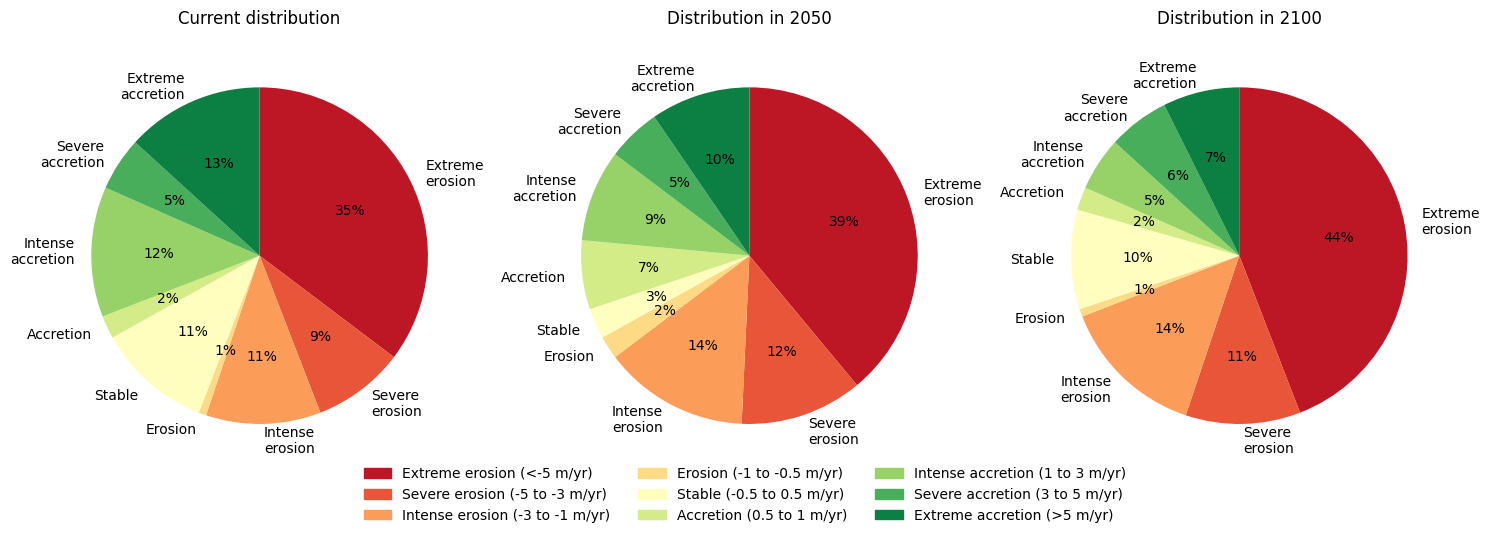

In [295]:
# Plot area of interest
plot_aoi(gdf_aoi)

# Get description
description = describe_changerate(ds_ls[2], 'changerate')

# Print description
n = 150
for i in range(0, len(description), n):
    print(description[i:i+n])

# Plot change rate
plot_changerate(ds_ls[2], gdf_aoi)

# Plot future change rate
plot_future_changerate(ds_ls[2], gdf_aoi)